## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Goal is to work through notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability



In [265]:
#import neccessary packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [266]:
#read ab_data.csv file
df =pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [267]:
#number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [268]:
#number of unique users
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [269]:
#propotion of converted
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [270]:
#number of times the new_page and treatment don't match
df[((df['group'] == 'treatment') == (df['landing_page'] == 'old_page'))].shape[0]

3893

f. Do any of the rows have missing values?

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


>None of the columns have missing values

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [272]:
#create a dataset d2 with where treatment match new_page and control match old_page
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))] 


In [273]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [274]:
#number of unique users
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [275]:
#how many user_id repeated
df2['user_id'].duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [276]:
#find the duplicate rows for user_id
dup = df2[df2['user_id'].duplicated(keep = False)]
dup

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [277]:
#drop the row 2893
df2 = df2.drop(df2.index[2893])
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [278]:
#probability of individual converting
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [279]:
#probability of individual in control converting
(df2.query('group == "control"')['converted']).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [280]:
#probability of individual in treatment converting
(df2.query('group == "treatment"')['converted']).mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [281]:
#probability of individual recieves a new_page
(df2['landing_page']=='new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>Probability of an individual converting in treatment group is only 11% which is not sufficient to decide new treatment page lead to more converting. Moreover propotion of control group converting is 12%, which is 1% higher than the treatment group which is negatively influence the statement that new treatment page lead to more converting.

>Proportion of landing_page being a new_page is 50%, which shows that individuals have recieved an equal number of new_page and old_page. Which is not biased to control group or treatment group to lead more converting.

>Therfore there is no sufficient evidence to conclude that the new treatment page leads to more conversions.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Null Hypothesis          **$p_{old}$** - **$p_{new}$** >= 0

#### Alternative Hypothesis   **$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [282]:
#conversion rate for new_page
new_page = df2.query('landing_page=="new_page"')
new_c= new_page.query('converted == "1"').user_id.nunique() / new_page.shape[0]
new_c

0.11880806551510564

In [283]:
#conversion rate for old_page
old_page = df2.query('landing_page=="old_page"')
old_c= old_page.query('converted == "1"').user_id.nunique() / old_page.shape[0]
old_c

0.1203863045004612

In [284]:
#difference between the convertion rates
p_diff_obs = old_c - new_c  
p_diff_obs

0.0015782389853555567

>under null hypothesis **p_old = p_new**

In [285]:
#p_new and p_old under null hypothesis
p_new = p_old = (new_c + old_c)/2
p_new, p_old

(0.11959718500778342, 0.11959718500778342)

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [286]:
#convertion rate for p_old
p_old
#difference between the convertion rate under null hypothesis
p_diffs = p_old - p_new
p_diffs

0.0

c. What is $n_{new}$, the number of individuals in the treatment group?

In [287]:
#number of users in treatment group
n_new = df2.query('group=="treatment"')
n_new.shape[0]


145310

d. What is $n_{old}$, the number of individuals in the control group?

In [288]:
#number useres in control group
n_old = df2.query('group=="control"')
n_old.shape[0]


145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [289]:
#simulate sample for treatment group using p_new rate
new = np.random.choice([0,1], size = (n_new.shape[0]), p = [(1-p_new),p_new])
new


array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [290]:
#simulate sample for treatment group using p_old rate
old = np.random.choice([0,1], size = (n_old.shape[0]), p = [(1-p_old),p_old])
old


array([0, 0, 0, ..., 0, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [291]:
#find converting rate for each group under null hypothesis
p_new1 = (new==1).mean()
p_old1 = (old==1).mean()

#difference between the convertion rate
p_diff_new = p_old1 - p_new1
p_diff_new

0.00029794922008259672

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [292]:
#array to hold the difference of convertions rate
p_diffs = []
#simulate 10,000 p_difference 
for _ in range(10000):
    new = np.random.choice([0,1], size = (n_new.shape[0]), p = [(1-p_new),p_new])
    old = np.random.choice([0,1], size = (n_old.shape[0]), p = [(1-p_old),p_old])
    p_new1 = (new==1).mean()
    p_old1 = (old==1).mean()
       
    p_diffs.append(p_old1 - p_new1)


In [293]:
#store the difference in numpy array
p_diffs = np.array(p_diffs)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

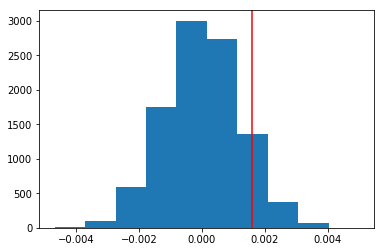

In [294]:
#plot histogram for p_diff under null hypothesis
plt.hist(p_diffs)
# Plot observed statistic with the null distibution
plt.axvline(p_diff_obs, c='red')

> Above histogram is abide with the central limit theorom.
> When the sample size is simulated to larger values the sampling distribution becomes normal.
> Sampling distribution of the mean value of difference between the convertion rate under null hypothesis is normally distributed which statisfies the central limit theorom. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [295]:
#calculate p_value
(p_diffs > p_diff_obs).mean()

0.10009999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>The above calulated statistic is called p_value. Which use to determine the likihood of observed mean value of the sample comes under the null hypothesis. 
>P_value for the above null distribution is 10.00% which is greater than Type I error rate of 5%. Therefore, 10.00% of values from  null distribution fall to the right, or are above, observed mean. So probability of the observed difference in converted rate in the sample is more likely to have come from the above null distribution. So we fail to reject the null hypothesis.
>In conclusion, on average convertion rate of old page is higher or equals to the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [296]:
import statsmodels.api as sm

df_old = df2[df2['landing_page']=='old_page']
convert_old_df = df_old[df_old['converted']==1]
convert_old = convert_old_df.shape[0]

df_new = df2[df2['landing_page']=='new_page']
convert_new_df = df_new[df_new['converted']==1]
convert_new = convert_new_df.shape[0]

n_old = (df2['landing_page']=='old_page').sum()
n_new = (df2['landing_page']=='new_page').sum()

n_total = n_old + n_new




m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [297]:
from statsmodels.stats.proportion import proportions_ztest
#under null hypothesis p_old = p_new
stat, pval = proportions_ztest((convert_new + convert_old), n_total, p_old)
print('{0:0.3f}'.format(pval))
print('{0:0.3f}'.format(stat))


1.000
-0.000


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>The p_value calculated is 1.00 which sufficient evidence to support fail to reject the null hypothesis meaning new_page do not influences the convertion rate than the old page or old page influences more convertion rate. 

>observed a 0.00 z-score, means the data value is identical to observed mean. Negative score indicating it is below the mean


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [298]:
#add an intercept
df2['intercept']=1
#create dummy variable ab_page for converted column
df2[['cnt','ab_page']]= pd.get_dummies(df2['group'])
df2.drop(['cnt'], axis=1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


In [299]:
#create dummy variables for landing_page
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [300]:
#build a logistic model
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page','new_page']])
result = logit.fit()


         Current function value: 0.366118
         Iterations: 35


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [301]:
#provide summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                 Logit              No. Iterations:     35.0000    
Dependent Variable:    converted          Pseudo R-squared:   0.000      
Date:                  2020-05-13 23:08   AIC:                212780.3502
No. Observations:      290584             BIC:                212801.5095
Df Model:              1                  Log-Likelihood:     -1.0639e+05
Df Residuals:          290582             LL-Null:            -1.0639e+05
Converged:             0.0000             Scale:              1.0000     
-------------------------------------------------------------------------
           Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
-------------------------------------------------------------------------
intercept -1.9888      0.0081 -246.6690 0.0000       -2.0046      -1.9730
ab_page   -0.0075 704237.3061   -0.0000 1.0000 -1380279.7641 1380279.7491
new_page  -0.0075 704237.3061   -0.0000 1.0000 -1380279.7641 1380279.7491
=========================================================================

"""

In [302]:
#exponentiate the coefficients
coef_abpage = np.exp(-0.0075)
coef_newpage = np.exp(-0.0075)
print('coef_abpage:',coef_abpage)
print('coef_newpage:',coef_newpage)

coef_abpage: 0.992528054819
coef_newpage: 0.992528054819


In [303]:
#compute the reciprocal
coef_abpage = 1/np.exp(-0.0075)
coef_newpage = 1/np.exp(-0.0075)
print('coef_abpage:',coef_abpage)
print('coef_newpage:',coef_newpage)

coef_abpage: 1.00752819544
coef_newpage: 1.00752819544


>**Model Interpretation:**

>Treatment group is 1.0075 times less likely to convert than the control group holding all other constant.

>Individuals who recieved new page is 1.0075 time less likely to convert than the individuals recieved old_page holding all other constant.

>Both the variables have a higher p-value which shows they are not statisticaly significant to predict whether or not an individual converts.

>Model has a 0.00 Pseudo R Squared, which shows the good fit of the model.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

>p_value associated with ab_page is 1.000. In Logistic regression null hypothesis is, ab_page is not associated with the value of the independent variable converted. Here the p-value tries to prove whether the ab_page is statistically significant to the model.

> For the results above, we would consider removing ab_page as the value is above 0.05. Keeping variables that are not statistically significant can reduce the model’s precision. But group type, whether the individual from a treatment group or control group is a important to factor to the analysis.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>Adding additional variables can increase the coefficient of ab_page and increase the good fit of the model. But if there is a multicollinearity between variables this can hinder the accuracy of the model.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [304]:
#read countries file
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [305]:
#find the number of entries for each country
df_countries['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [306]:
#join df_countries with df2
df2 = df2.set_index('user_id').join(df_countries.set_index('user_id'))

In [307]:
#create dummy variables
df2[['CA','UK','US',]] = pd.get_dummies(df2['country'])
df2.head()

,timestamp,group,landing_page,converted,intercept,cnt,ab_page,new_page,old_page,country,CA,UK,US
user_id,,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,1,0,US,0,0,1
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,1,0,US,0,0,1
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,0,1,US,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,1,0,US,0,0,1
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,1,0,US,0,0,1


In [308]:
#find the converted rate for each country
df2.groupby(df2['country'])['converted'].mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [309]:
#model logistic regression using ab_page, US, UK
logit = sm.Logit(df2['converted'],df2[['intercept','new_page','US','UK','ab_page']])
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit             No. Iterations:    6.0000     
Dependent Variable:   converted         Pseudo R-squared:  0.000      
Date:                 2020-05-13 23:08  AIC:               212781.1253
No. Observations:     290584            BIC:               212823.4439
Df Model:             3                 Log-Likelihood:    -1.0639e+05
Df Residuals:         290580            LL-Null:           -1.0639e+05
Converged:            1.0000            Scale:             1.0000     
----------------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|     [0.025       0.975]  
----------------------------------------------------------------------
intercept -2.0300      0.0266 -76.2488 0.0000      -2.0822     -1.9778
new_page  -0.0075 352118.6531  -0.0000 1.0000 -690139.8858 690139.8708
US         0.0408      0.0269   1.5161 0.1295      -0.0119      0.0934
UK         0.0506      0.0284   1.7835 0.0745      -0.0050      0.1063
ab_page   -0.0075 352118.6531  -0.0000 1.0000 -690139.8858 690139.8708
======================================================================

"""

In [310]:
#exponentiate the coefficients
coef_abpage = np.exp(-0.0075)
coef_newpage = np.exp(-0.0075)
coef_US = np.exp(0.0408)
coef_UK = np.exp(0.0506)
print('coef_abpage', coef_abpage)
print('coef_newpage', coef_newpage)
print('coef_US', coef_US)
print('coef_UK', coef_UK)

coef_abpage 0.992528054819
coef_newpage 0.992528054819
coef_US 1.04164375596
coef_UK 1.0519020483


In [311]:
#compute reciprocal
coef_abpage = 1/np.exp(-0.0075)
coef_newpage = 1/np.exp(-0.0075)
print('coef_abpage', coef_abpage)
print('coef_newpage', coef_newpage)

coef_abpage 1.00752819544
coef_newpage 1.00752819544


>**Model Interpretation:**
>Coefficient of ab_page remains the same even after adding variables, treatment group is 1.0075 times less likely to convert than the control group holding all other constant.

>coefficient of new_page remains the same, individual who recieved new_page 1.98 times less likely to convert than the individual who recieved old_page holding all other constant.

>Individual in United States are 1.04 times as likely to convert to those in Canada holding all other constant.

>Individual in United States are 1.05 times as likely to convert to those in Canada holding all other constant.

>**Accuracy Test:** Calculate the confusion matrix, accuracy, recall_score and precision_score

In [312]:
y = df2['converted']
x = df2[['ab_page', 'new_page', 'US','UK']]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20, random_state=42)

In [313]:
log_mod = LogisticRegression()
log_mod.fit(x_train, y_train)
y_preds = log_mod.predict(x_test)
#Create a confusion matric
confusion_matrix(y_test, y_preds)
                      

array([[51140,     0],
       [ 6977,     0]])

>51140 of 0's are correctly predicted as 0's and none of the 1's are predicted as 1.

In [314]:
precision_score(y_test,y_preds)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [315]:
recall_score(y_test, y_preds)

0.0

In [316]:
accuracy_score(y_test, y_preds)

0.8799490682588571

>Accuracy of the above model is 87.9%

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [317]:
#create interaction row for new_page and countries
df2['new_US'] = df2['new_page']*df2['US']
df2['new_UK'] = df2['new_page']*df2['UK']
df2['new_CA'] = df2['new_page']*df2['CA']

In [318]:
df2.head()

,timestamp,group,landing_page,converted,intercept,cnt,ab_page,new_page,old_page,country,CA,UK,US,new_US,new_UK,new_CA
user_id,,,,,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,1,0,US,0,0,1,1,0,0
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,0,1,US,0,0,1,0,0,0
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0


In [319]:
#fit model
logit = sm.Logit(df2['converted'],df2[['intercept','new_US','new_UK']])
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-13 23:08 AIC:              212781.7674
No. Observations:   290584           BIC:              212813.5064
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
new_US       -0.0144    0.0125    -1.1548  0.2482  -0.0389   0.0101
new_UK        0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
==================================================================

"""

In [320]:
#exponentiate the coefficients
coef_newUS = np.exp(-0.0144)
coef_newUK = np.exp(0.0112)
print('coefficient of new_US', coef_newUS)
print('coefficient of new_UK', coef_newUK)

coefficient of new_US 0.985703184122
coefficient of new_UK 1.01126295481


In [321]:
#compute reciprocal
coef_newUS = 1/np.exp(-0.0144) 
print('coefficient of new_US', coef_newUS)

coefficient of new_US 1.01450417946


>**Model Interpretation**
>Individuals who recieved a new page in UK are 1.011 times more likely to convert than those individual recieved new_page in Canada holding all other constant.

>Individuals who recieved a new page in US are 1.014 times less likely to convert than those individual recieved new_page in Canada holding all other constant.

In [322]:
#create hour column to hold the hour value from timestamp
df2['timestamp'] = pd.to_datetime(df2['timestamp']) 
df2['hours'] = df2['timestamp'].dt.hour
df2.head()


,timestamp,group,landing_page,converted,intercept,cnt,ab_page,new_page,old_page,country,CA,UK,US,new_US,new_UK,new_CA,hours
user_id,,,,,,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0,6
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,1,0,US,0,0,1,1,0,0,3
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,0,1,US,0,0,1,0,0,0,19
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0,10
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0,20


In [323]:
#create day_time columns variable to partition the hour variable
time =[]
for row in df2['hours']:
    if row >=6 and row <=18:
        time.append('day_time')
    elif row <=6:
         time.append('night_time')
    elif row>=18 and row<=23:
        time.append('night_time')

df2['day_time'] = time

df2.head()


,timestamp,group,landing_page,converted,intercept,cnt,ab_page,new_page,old_page,country,CA,UK,US,new_US,new_UK,new_CA,hours,day_time
user_id,,,,,,,,,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0,6,day_time
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,1,0,US,0,0,1,1,0,0,3,night_time
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,1,0,0,1,US,0,0,1,0,0,0,19,night_time
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0,10,day_time
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,1,0,US,0,0,1,1,0,0,20,night_time


In [324]:
#get dummy variables
df2[['day_time','night_time']]=pd.get_dummies(df2['day_time'])

In [325]:
#create interaction row for newday, country and day_time
df2['new_US_day'] = df2['new_UK']*df2['day_time']
df2['new_UK_day'] = df2['new_US']*df2['day_time']
df2['new_CA_day'] = df2['new_CA']*df2['day_time']

In [326]:
#fit model
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page','new_US_day','new_UK_day','day_time']])
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366104
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-13 23:08 AIC:              212778.2152
No. Observations:   290584           BIC:              212831.1134
Df Model:           4                Log-Likelihood:   -1.0638e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0062    0.0117  -171.8903  0.0000  -2.0291  -1.9834
ab_page      -0.0114    0.0161    -0.7086  0.4786  -0.0430   0.0201
new_US_day    0.0178    0.0287     0.6206  0.5349  -0.0384   0.0740
new_UK_day   -0.0159    0.0228    -0.6952  0.4869  -0.0606   0.0289
day_time      0.0321    0.0154     2.0802  0.0375   0.0019   0.0623
==================================================================

"""

In [327]:
#exponentiate the coefficients
coef_newUS=np.exp(0.0178)
coef_newUK = np.exp(-0.0159)
coef_daytime = np.exp(0.0372)
coef_ab_page = np.exp(0.0114)
print('coefficient of new_US', coef_newUS)
print('coefficient of new_UK', coef_newUK)
print('coefficient of day_tiem', coef_daytime)
print('coefficient of ab_page', coef_ab_page)

coefficient of new_US 1.01795936416
coefficient of new_UK 0.984225737708
coefficient of day_tiem 1.0379005802
coefficient of ab_page 1.01146522763


In [328]:
#Calculate reciprocal
coef_newUK=1/np.exp(-0.0267)

print('coefficient of new_UK', coef_newUS)


coefficient of new_UK 1.01795936416


>**Model Interpretation**
>Individual in UK recieved a new_page in day time is 1.017 times less likely to convert than who recieved in CA holding all other constant.

>Individual in US recieved a new_page in day time is 1.017 times likely to convert than who recieved in CA holding all other constant.

>Individual who recieved any type of page is 1.03 time as likely to convert than night time holding all other constant. Variable day_time has a low p_value meaning this is statistically significant to predict whether page type influence the convertion rate over the other.

>Individual who is in treatment group 1.011 times as likely to convert than in the control group holding all other constant. 

>This model seems to be a good fit as p-values for of the interacted variables have gone done, which suggests that now they are statistically significant to the model.

>P-value ab_page also have slightly decreased comparing to other models

In [329]:
y = df2['converted']
x = df2[[ 'new_US_day','new_UK_day','day_time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

In [330]:
log_mod = LogisticRegression()
log_mod.fit(x_train, y_train)
y_preds = log_mod.predict(x_test)
#Create a confusion matric
confusion_matrix(y_test, y_preds)

array([[25585,     0],
       [ 3474,     0]])

>25585 of 0's are correctly predicted as 0's and none of the 1s are predicted as 1.

In [331]:
#accuracy test of the model
accuracy_score(y_test, y_preds)

0.88045011872397538

>Accuracy of this model is 88.04%

### Conclusion: 
>**Statistical Aspects**
>In the statistical analysis we failed to reject the null hypothesis, meaning old page led to more convertion than the new users. But there is a very small different in the observed conversation rate in individuals who recieved new page to old page in the sample. Which suggests that there are possible drawbacks in the experiment.

>Even though old page users converstion rate is considered better than new version, it is still difficult to conclude. Odd ratios of new_page seem to be higher than the old page but the rate is relatively low.  Variables ab_page and new_page p_values remained higher than the typeI error threshold value for all models generated, showing that they are not statistically significant to predict the conversion rate.
 
>**Practical Aspects**
>Existing users may unhappy with the change therefore it might take sometime for them to get used to the new feature. This may lead to less conversation rate which can biased to old version.  

>Existing users may found it difficult or confused to handle the new version, this also can made them to reluctant to convert.


> Calculate the time duration for this experiment

In [332]:
(df2['timestamp'].max() - df2['timestamp'].min())

Timedelta('21 days 23:59:49.081927')

>Since the experiment conducted for only 21 days, it is sensible to extent the experiment to avoid cahnge aversion . However, How long do this experiment should run to achieve a better decision is a question. 

>In conclusion this experiment should run longer to make a better decision.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [334]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0